In [2]:
# coding: utf-8
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pystan
import pickle
import phasekickstan as p
import h5py
import phasekick
import pmefm
import lockin
import os
from scipy.optimize import curve_fit, root
from scipy import optimize
from tqdm import tqdm
from collections import OrderedDict

def tdf2data_transformed(t, df, Ndec):
    t_med = np.mean(t, axis=0)[::Ndec]*1e3
    df_med = np.mean(df, axis=0)[::Ndec]
    Npts = t.shape[0]
    df_std = np.std(df, ddof=1, axis=0)[::Ndec]/Npts**0.5
    m = t_med <= 0
    y_neg = df_med[m]
    offset = np.mean(y_neg)
    
    return {'y_neg': y_neg - offset, 't': t_med[~m], 'N_neg':t_med[m].size, 'N': t_med[~m].size,
           'y_neg_err': df_std[m],
           'y': df_med[~m] - offset, 'y_err': df_std[~m], 'offset': offset
            }

def exp2(t, df, ratio, tau):
    return df * ( ratio*(1-np.exp(-t/tau[0])) + (1-ratio)*(1-np.exp(-t/tau[1])))


def root_exp2(df, ratio, tau, df_e, x0=0.):
    return root(lambda t: exp2(t, df, ratio, tau) - df_e, 0.)

def get_approx_tau(gr, ratio=(1-np.exp(-1)), absolute=None, N=1000):

    
    
    tau = p.percentile_func(gr['params/tau'][:])
    df_inf = p.percentile_func(gr['params/df_inf'][:])
    df_ratio = p.percentile_func(gr['params/df_ratio'][:])
    
    df = df_inf(50)
    if absolute is None:
        df_e = df * ratio
    else:
        df_e = absolute
    
    out_min = root_exp2(df_inf(97.5), df_ratio(97.5), tau(2.5), df_e)
    out_max = root_exp2(df_inf(2.5), df_ratio(2.5), tau(97.5), df_e)
    t = np.linspace(out_min['x'][0], out_max['x'][0], N)
    

    Df = p.fh_exp_doub2df(gr, t=t)
    Dfp = p.percentile_func(Df)
    t50 = t[np.argmax(Dfp(50) < df_e)]
    t15 = t[np.argmax(Dfp(15.9) < df_e)]
    t85 = t[np.argmax(Dfp(84.1) < df_e)]
    return t15, t50, t85

def exprisefall(t, tau, tf, ti=0):
    return np.where(t < ti, 0,
             np.where( t < tf,
                      1-np.exp(-(t-ti)/tau),
                      (1-np.exp(-(tf-ti)/tau))*np.exp(-(t-tf)/tau)
        ))



def align_labels(axes_list,lim, axis='y'):
    for ax in axes_list:
        t = ax.yaxis.label.get_transform()
        x,y = ax.yaxis.label.get_position()
        ax.yaxis.set_label_coords(lim,y,t)

In [6]:
mpl.rc('font', size=10)
fh = h5py.File('../data/pk-efm/151217-205912-p3sun-phasekick.h5', 'r')

gr = fh['data/0058']
li12 = phasekick.gr2lock(gr, 750, 750*4)
li12.lock_butter(1, 500, t_exclude=2e-3)
li12.phase(tf=-0.051)

li1 = phasekick.gr2lock(gr, 750, 750*4)

maxes = ('none', 0)
for ds_name, ds in fh['data'].items():
    tp = ds.attrs['Abrupt BNC565 CantClk.tp tip [s]']
    if tp > maxes[1]:
        maxes = (ds_name, tp)

od = OrderedDict([(ds_name, ds.attrs['Abrupt BNC565 CantClk.tp tip [s]']) for ds_name, ds in fh['data'].items()])
od_sorted = OrderedDict(sorted(od.iteritems(), key=lambda x: x[1]))
ds_mid = od_sorted.items()[36][0]
gr_mid = fh['data'][ds_mid]

size = 10
rcParams = {'figure.figsize': (3, 5.), 'font.size': size,
            'lines.markersize': 6,
            'lines.linewidth': 1,
            'xtick.labelsize': size, 'ytick.labelsize': size,}

t = li12('t')*1e3
tp1 = tp = 0.01032533*1e3
li1.phase(ti=-0.0015, tf=-0.0005)

gr3c = fh['control/0024']

li3c = phasekick.gr2lock(gr3c, 750, 750*4)
li3c.phase(ti=-0.0015, tf=-0.0005)
li32c = phasekick.gr2lock(gr3c, 750, 750*4)
li32c.phase(tf=-0.051)

i = 52
ds3 = od_sorted.items()[i][0]
tp3 = od_sorted.items()[i][1]*1e3
gr3 = fh['data'][ds3]
li3 = phasekick.gr2lock(gr3, 750, 750*4)
li32 = phasekick.gr2lock(gr3, 750, 750*4)
li3.phase(ti=-0.0015, tf=-0.0005)
li32.phase(tf=-0.051)

i2 = 22
ds_mid = od_sorted.items()[i2][0]
gr_mid = fh['data'][ds_mid]
li_mid = phasekick.gr2lock(gr_mid, 750, 750*4)
li_mid2 = phasekick.gr2lock(gr_mid, 750, 750*4)
tp2 = od_sorted.items()[i2][1]*1e3
li_mid.phase(ti=-0.0015, tf=-0.0005)
li_mid2.phase(tf=-0.051)

ticksize=10
rcParams = {'figure.figsize': (3.2, 4.5), 'font.size': size,
            'lines.markersize': 6,
            'lines.linewidth': 1,
            'xtick.labelsize': size, 'ytick.labelsize': size,}

b1 = 0.8
a1 = 0.6
a2 = 0.8

grey = 0.75*np.array(mpl.cm.Greys(0.6)[:-1])

green = 2.5*np.array([0., 0.1, 0.])
purple = 2.5*np.array([0.05, 0, 0.05])
blue = 2.5*np.array([0, 0, 0.1])


c2blue = blue_dark = (0.1, 0.3, 0.6)

c2 = {'color': grey, 'alpha': 0.8}
c3 = {'color': (0.1, 0.3, 0.6), 'linewidth':1.3}
c1 = {'color': mpl.cm.Greys(0.6), 'alpha': 0.5}

# Put all things in a tuple!
# (t, tp, li, li2, colors, alpha, linewidth)
gl = 1.0
gd = 0.5
cl = 1.0
cd = 1.75
all_lines = [(t, tp1, li1, li12, ['k', 'g', 'm', c2blue, c2blue], 1.0, 1.3),
 (t, tp3,  li_mid, li_mid2, [mpl.cm.Greys(0.8), grey*gd+cd*green, grey*gd+cd*purple, grey*gl+cl*blue, grey*gl+cl*blue], 0.9, 1.0),
 (t, tp2, li3, li32, [mpl.cm.Greys(0.5), grey*gl+cl*green, grey*gl+cl*purple, grey*gd+cd*blue, grey*gd+cd*blue], 0.6, 1.0)]


with mpl.rc_context(rcParams):
    fig = plt.figure()
    gs = gridspec.GridSpec(8,1)
    gs.update(wspace=0.025, hspace=0.002) # set the spacing between axes.
    ax1 = fig.add_subplot(gs[2],)
    ax00 = fig.add_subplot(gs[0], sharex=ax1)
    ax01 = fig.add_subplot(gs[1], sharex=ax1)
    ax2 = fig.add_subplot(gs[3], sharex=ax1)
    ax3 = fig.add_subplot(gs[4], sharex=ax1)
    ax4 = fig.add_subplot(gs[5:])
#     ax5 = fig.add_subplot(gs[8:])

    for (t, tp, li, li2, color, alpha, linewidth) in all_lines:
        t = li('t')*1e3
        ax00.plot(li('t')*1e3, li('A'), color=color[4], alpha=alpha, linewidth=linewidth)
        ax01.plot(t, np.where((t >= -10), 0, 1), color=color[0], alpha=alpha, linewidth=linewidth)
        ax1.plot(t, np.where((t >= -50) & (t <tp), 1, 0), color=color[0], alpha=alpha, linewidth=linewidth)
        ax2.plot(t, np.where((t >= 0) & (t <tp), 1, 0), color=color[1], alpha=alpha, linewidth=linewidth)
        ax3.plot(t, 1-exprisefall(t, 2.5, tp), color=color[2], alpha=alpha, linewidth=linewidth)
        ax4.plot(li2('t')*1e3, li2('df'), color=color[3], alpha=alpha, linewidth=linewidth)
#         ax5.plot(li('t')*1e3, li('dphi'), color=color[4], alpha=alpha, linewidth=linewidth)

    ax01.set_ylim(-0.2, 1.2)
    ax01.set_yticks([0, 1])
    ax01.set_yticklabels(['$0$', ''])
    ax00.set_yticks([40, 50])
    ax00.set_yticklabels(['$40$', '$50$'])
    
    ax1.set_yticks([0, 1])
    ax2.set_yticks([0, 1])
    ax1.set_ylim(-0.2, 1.2)
    ax2.set_ylim(-0.2, 1.2)
    ax3.set_ylim(-0.2, 1.2)
    ax3.set_yticks([0, 1])
    ax2.set_yticklabels(['$0$', '$\quad \quad \:\:\:$'], fontsize=ticksize)
    ax1.set_yticklabels(['$0$', '$\quad \quad \:\:\:$'], fontsize=ticksize)
    ax3.set_yticklabels([r'$\quad \quad \:\:\:$', ''])


#     ax5.set_ylim(5.6, 6.4)
#     ax5.set_yticks(np.linspace(5.6, 6.2, 4))
#     ax5.set_yticklabels(["${}$".format(i) for i in [r"\: \: \: 5.6", "5.8", "6.0", "6.2"]])
    ax1.set_xticks([-50, -10, 0, 10])
    ax1.set_xticklabels(['' for item in ax1.get_xticklabels()])
    ax4.set_xticks([-50, -10, 0, 10])
    ax4.set_xticklabels(["${}$".format(i) for i in ["-50", "-10", "0", "10"]])
    
    ax4.set_xlabel('$t \: [\mathrm{ms}]$', fontsize=size)
    
    ax00.set_ylabel(r'$A \: \: [\mathrm{nm}]$')
    ax01.set_ylabel(r'$V_\mathrm{d}$')
    ax1.set_ylabel(r'$V_\mathrm{t}$', fontsize=size)
    ax2.set_ylabel(r'$I_{h\nu}$', fontsize=size)
    ax3.set_ylabel(r"$-C''$")
    ax4.set_yticklabels(['${}$'.format(x) for x in xrange(-200, 25, 50)],
                        fontsize=size)
    ax4.set_ylabel(r'$-C'' V^2_{\mathrm{t}} \: \: \propto \: \: \delta f \: \: [\mathrm{Hz}]$', fontsize=size)
#     ax5.set_ylabel(r'$\delta \phi \: [\mathrm{cyc.}]$', fontsize=size)
    for ax in [ax1, ax2, ax3, ax00, ax01]:
        ax.axvline(-50, color='k', linestyle='dotted')
        ax.axvline(0, color='k', linestyle='dotted')
    
    for ax in [ax1, ax4]:
        ax.set_xlim(-55, 12.5)

#     ax00.set_xlim(-55, 12.5)
#     ax5.set_xlim(-55, 12.5)
    ax4.set_ylim(-170, 10)


align_labels([ax00, ax01, ax1, ax2, ax3, ax4,
#               ax5
             ], 32)



Response:
f   mag       dB
    0.000 1.000    0.000
  250.000 0.894   -0.969
  500.000 0.707   -3.010
30926.304 0.016  -35.856
61852.608 0.008  -41.958
500000.000 0.000 -380.338


In [7]:
fh.attrs.items()

[(u'Microscope Parameters.Cantilever', 'Nathan-pre-1509'),
 (u'Microscope Parameters.Q', 31000.0),
 (u'Microscope Parameters.Sample', 'F8BT-PFB-Nathan-1509'),
 (u'Microscope Parameters.fc [Hz]', 62001.0),
 (u'Microscope Parameters.kc [Hz]', 3.5),
 (u'z [nm]', 290.0),
 (u'wait [ms]', 1500),
 (u'PLL Settings out.Amplitude Scaling', 1.0),
 (u'PLL Settings out.Center Frequency', 62000.2163),
 (u'PLL Settings out.Frequency I', 2.5),
 (u'PLL Settings out.Frequency P', -12.0),
 (u'PLL Settings out.Frequency Scaling', 20.0),
 (u'PLL Settings out.Phase Shift', -119.13)]

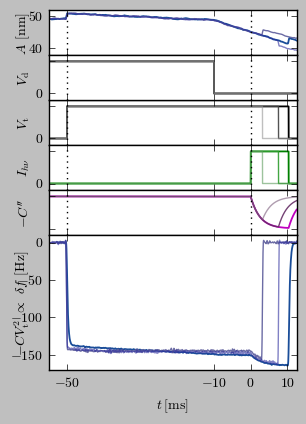

In [8]:
fig

In [9]:
fig.savefig('ex.pdf', bbox_inches='tight', pad_inches=0.5, transparent=True)

In [10]:
!open ex.pdf

In [11]:
!cp ex.pdf /Users/ryandwyer/Dropbox/_JAM_MS__Dwyer201511__Phasekick__figs/raw-figures/02-revised-A-Vd.pdf